# Ridge Regression

Original Data:
   distance_from_center  num_of_reviews
0                   1.9          4667.0
1                   1.5          3243.0
2                   6.9           534.0
3                   1.4          2484.0
4                   1.9          2028.0

Standard Scaled Data:
   distance_from_center  num_of_reviews
0             -0.399995        0.438408
1             -0.622470        0.043063
2              2.380950       -0.709037
3             -0.678089       -0.167658
4             -0.399995       -0.294258
Test Set Results:
   Alpha  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      1       691257.644703               831.419055           613.968857   
1      5       691256.175032               831.418171           613.957540   
2     10       691254.396667               831.417101           613.943406   
3     50       691242.513174               831.409955           613.832346   
4    100       691233.490825               831.404529           613.697780

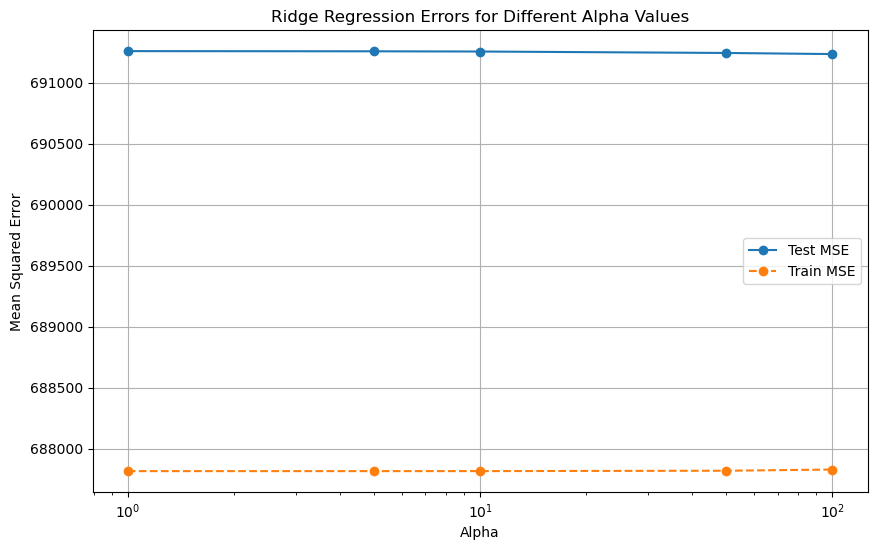

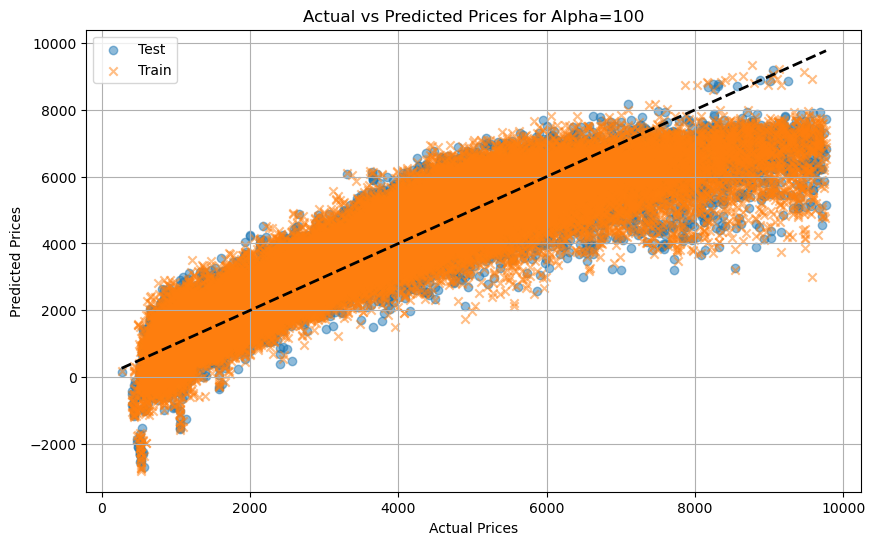

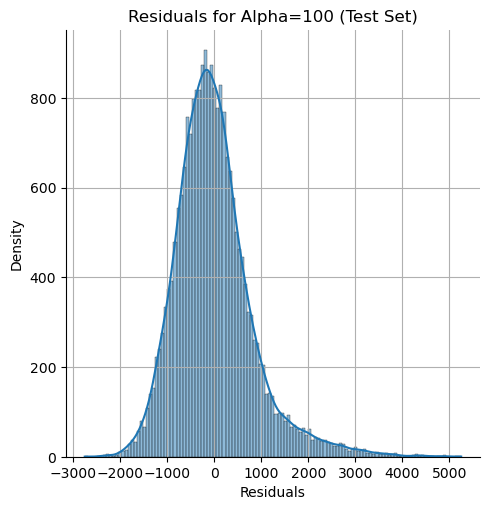

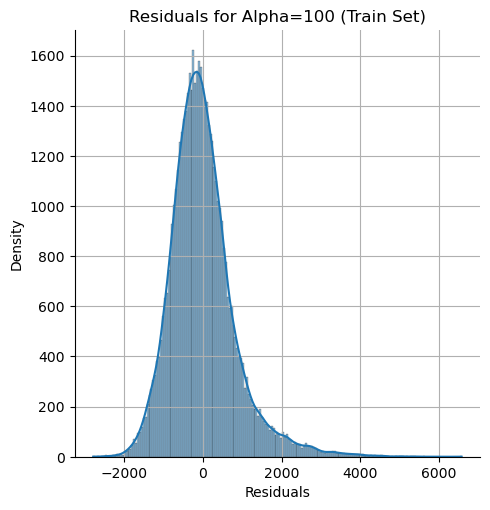

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the data
data = pd.read_csv('booking_data.csv')
def convert_to_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

data['checkin_date'] = data['checkin_date'].apply(convert_to_date)
#data['checkin_day'] = data['checkin_date'].dt.day
data['checkin_month'] = data['checkin_date'].dt.month
o_data = data
# Remove the 'name' column

# Drop non-numeric columns that are not one-hot encoded
data = data.drop(columns=['name','checkout_date', 'Snapshot Date','checkin_date'])
columns_to_normalize = ['distance_from_center', 'num_of_reviews']

# Standardization
standard_scaler = StandardScaler()
data_standard_scaled = data.copy()
data_standard_scaled[columns_to_normalize] = standard_scaler.fit_transform(data[columns_to_normalize])

# הצגת הנתונים המנורמלים
print("Original Data:")
print(data[columns_to_normalize].head())

print("\nStandard Scaled Data:")
print(data_standard_scaled[columns_to_normalize].head())

# Separate features and target
X = data.drop(columns=['price'])
y = data['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to train and evaluate Ridge Regression with different alpha values
def evaluate_ridge(alpha_values, X_train, y_train, X_test, y_test):
    results = {}
    for alpha in alpha_values:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        
        # Evaluate on test set
        y_pred_test = ridge.predict(X_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        rmse_test = np.sqrt(mse_test)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        
        # Evaluate on train set
        y_pred_train = ridge.predict(X_train)
        mse_train = mean_squared_error(y_train, y_pred_train)
        rmse_train = np.sqrt(mse_train)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        r2_train = r2_score(y_train, y_pred_train)
        
        results[alpha] = {
            'test': {'mse': mse_test, 'rmse': rmse_test, 'mae': mae_test, 'r2': r2_test, 'y_pred': y_pred_test},
            'train': {'mse': mse_train, 'rmse': rmse_train, 'mae': mae_train, 'r2': r2_train, 'y_pred': y_pred_train}
        }
    return results

# Choose different values for alpha
alpha_values = [1, 5, 10, 50, 100]

# Evaluate Ridge Regression with different alpha values
results = evaluate_ridge(alpha_values, X_train_scaled, y_train, X_test_scaled, y_test)

# Convert results to DataFrames
results_df_test = pd.DataFrame([(a, res['test']['mse'], res['test']['rmse'], res['test']['mae'], res['test']['r2']) 
                                for a, res in results.items()],
                               columns=['Alpha', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])

results_df_train = pd.DataFrame([(a, res['train']['mse'], res['train']['rmse'], res['train']['mae'], res['train']['r2']) 
                                 for a, res in results.items()],
                                columns=['Alpha', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])

# Display results
print("Test Set Results:")
print(results_df_test)
print("\nTrain Set Results:")
print(results_df_train)

# Plot MSE for different alpha values
plt.figure(figsize=(10, 6))
plt.plot(results_df_test['Alpha'], results_df_test['Mean Squared Error'], marker='o', label='Test MSE')
plt.plot(results_df_train['Alpha'], results_df_train['Mean Squared Error'], marker='o', label='Train MSE', linestyle='--')
plt.title('Ridge Regression Errors for Different Alpha Values')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted values and residuals for best alpha (lowest test MSE)
best_alpha = results_df_test.loc[results_df_test['Mean Squared Error'].idxmin(), 'Alpha']
best_results = results[best_alpha]

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_results['test']['y_pred'], alpha=0.5, label='Test')
plt.scatter(y_train, best_results['train']['y_pred'], alpha=0.5, label='Train', marker='x')
plt.title(f'Actual vs Predicted Prices for Alpha={best_alpha}')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals for test set
residuals_test = y_test - best_results['test']['y_pred']
sns.displot(residuals_test, kde=True)
plt.title(f'Residuals for Alpha={best_alpha} (Test Set)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot residuals for train set
residuals_train = y_train - best_results['train']['y_pred']
sns.displot(residuals_train, kde=True)
plt.title(f'Residuals for Alpha={best_alpha} (Train Set)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

אם ערכי אר 2 כמעט זהים עבור ערכי אלפא
זה עשוי להעיד על כמה דברים:

1. רגישות נמוכה לערכי אלפא
המודל שלך עשוי להיות לא רגיש במיוחד לערכי האלפא שנבחרו. זה יכול להצביע על כך שהדאטה שלך או המודל יציבים יחסית לתנודות ברגולריזציה.

2. דאטה גדול/מאוזן
אם יש לך הרבה דוגמאות או שהדאטה מאוזן היטב, ההשפעה של הרגולריזציה עשויה להיות פחות משמעותית.

3. מימדיות נמוכה של הדאטה
אם מספר התכונות (features) קטן יחסית למספר הדוגמאות (samples), האפקט של הרגולריזציה עשוי להיות פחות ניכר.

# הוספת פיצ'רים

In [2]:
def convert_to_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

# הוספת פיצ'ר ליום בשבוע ע"ב תאריך צקאין
def get_day_of_week(date_obj):
    # קבלת מספר היום בשבוע (0 - ראשון, 1 - שני, וכן הלאה)
    day_of_week = date_obj.weekday()
    return day_of_week

# החלפת הערכים בעמודה 'bed_type' לערכי הסיווג החדש
o_data['checkin_day_week'] = o_data['checkin_date'].apply(get_day_of_week)

In [3]:
def classify_bed_type(value):
    if value == 7 or value == 8:
        return 1
    else:
        return 0

# החלפת הערכים בעמודה 'bed_type' לערכי הסיווג החדש
o_data['two_beds'] = o_data['bed_category'].apply(classify_bed_type)
o_data = o_data.drop(columns=['name','checkout_date', 'Snapshot Date','checkin_date'])


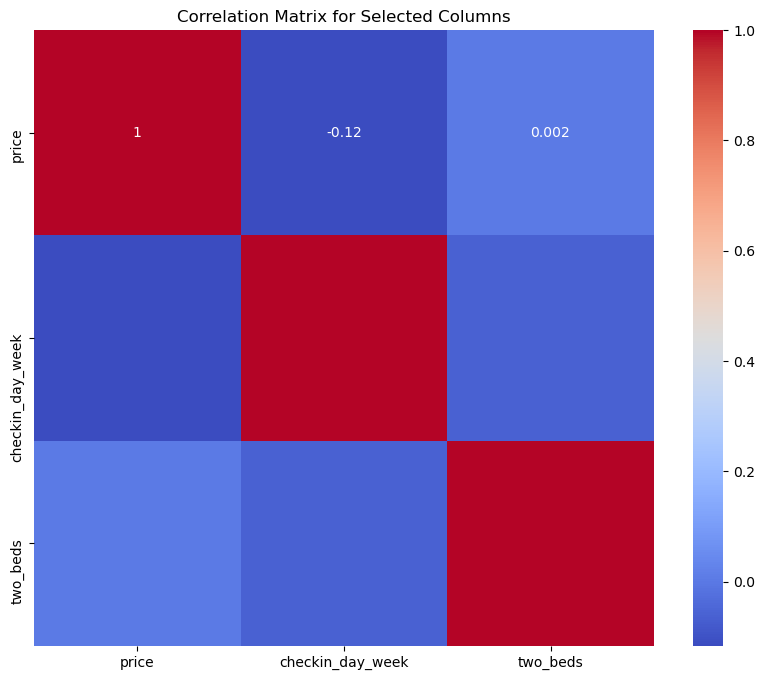

In [4]:
selected_columns = ['price', 'checkin_day_week', 'two_beds']

# יצירת DataFrame חדש עם העמודות הנבחרות
selected_data = o_data[selected_columns]

# חישוב מטריצת הקורלציה
correlation_matrix = selected_data.corr()

# הצגת מטריצת הקורלציה
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Selected Columns')
plt.show()

Original Data:
   distance_from_center  num_of_reviews
0                   1.9          4667.0
1                   1.5          3243.0
2                   6.9           534.0
3                   1.4          2484.0
4                   1.9          2028.0

Standard Scaled Data:
   distance_from_center  num_of_reviews
0             -0.399995        0.438408
1             -0.622470        0.043063
2              2.380950       -0.709037
3             -0.678089       -0.167658
4             -0.399995       -0.294258
Test Set Results:
   Alpha  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      1       691257.644703               831.419055           613.968857   
1      5       691256.175032               831.418171           613.957540   
2     10       691254.396667               831.417101           613.943406   
3     50       691242.513174               831.409955           613.832346   
4    100       691233.490825               831.404529           613.697780

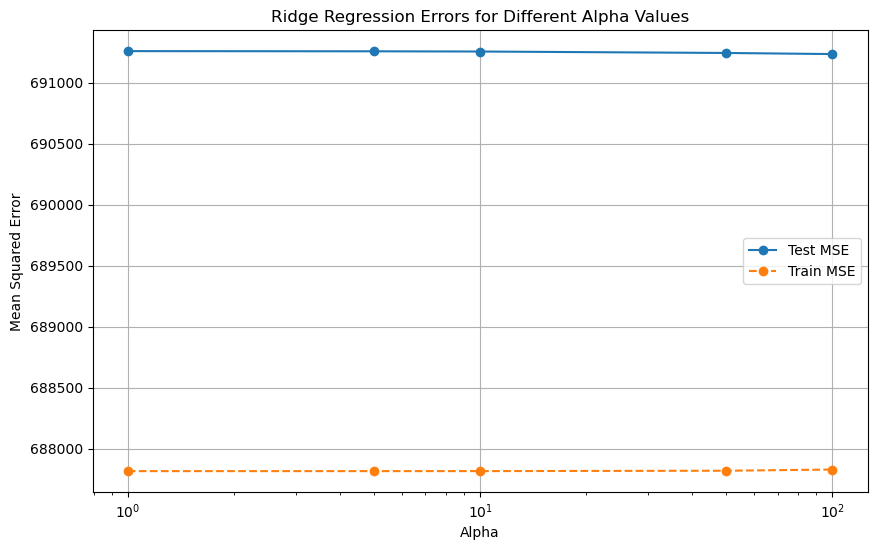

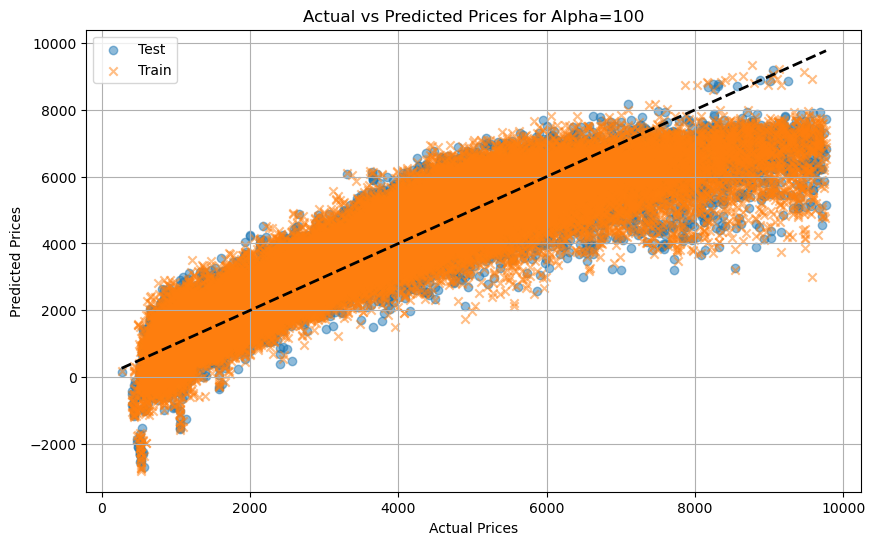

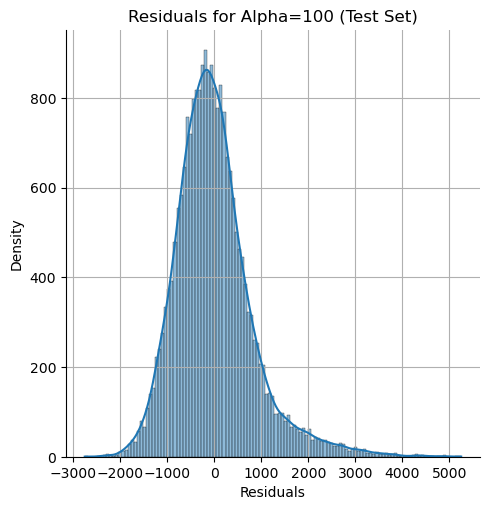

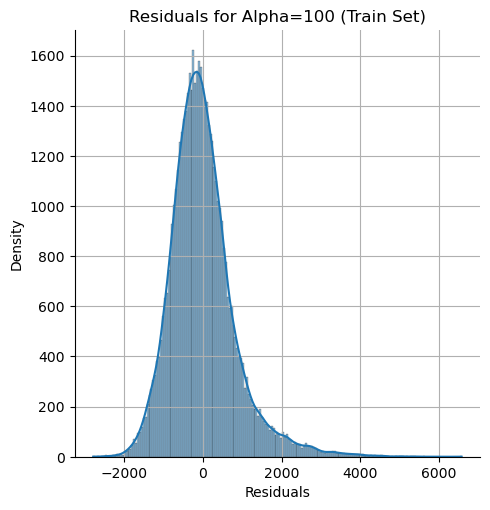

In [5]:
columns_to_normalize = ['distance_from_center', 'num_of_reviews']

# Standardization
standard_scaler = StandardScaler()
data_standard_scaled = data.copy()
data_standard_scaled[columns_to_normalize] = standard_scaler.fit_transform(data[columns_to_normalize])

# הצגת הנתונים המנורמלים
print("Original Data:")
print(data[columns_to_normalize].head())

print("\nStandard Scaled Data:")
print(data_standard_scaled[columns_to_normalize].head())

# Separate features and target
X = data.drop(columns=['price'])
y = data['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to train and evaluate Ridge Regression with different alpha values
def evaluate_ridge(alpha_values, X_train, y_train, X_test, y_test):
    results = {}
    for alpha in alpha_values:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        
        # Evaluate on test set
        y_pred_test = ridge.predict(X_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        rmse_test = np.sqrt(mse_test)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        
        # Evaluate on train set
        y_pred_train = ridge.predict(X_train)
        mse_train = mean_squared_error(y_train, y_pred_train)
        rmse_train = np.sqrt(mse_train)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        r2_train = r2_score(y_train, y_pred_train)
        
        results[alpha] = {
            'test': {'mse': mse_test, 'rmse': rmse_test, 'mae': mae_test, 'r2': r2_test, 'y_pred': y_pred_test},
            'train': {'mse': mse_train, 'rmse': rmse_train, 'mae': mae_train, 'r2': r2_train, 'y_pred': y_pred_train}
        }
    return results

# Choose different values for alpha
alpha_values = [1, 5, 10, 50, 100]

# Evaluate Ridge Regression with different alpha values
results = evaluate_ridge(alpha_values, X_train_scaled, y_train, X_test_scaled, y_test)

# Convert results to DataFrames
results_df_test = pd.DataFrame([(a, res['test']['mse'], res['test']['rmse'], res['test']['mae'], res['test']['r2']) 
                                for a, res in results.items()],
                               columns=['Alpha', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])

results_df_train = pd.DataFrame([(a, res['train']['mse'], res['train']['rmse'], res['train']['mae'], res['train']['r2']) 
                                 for a, res in results.items()],
                                columns=['Alpha', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])

# Display results
print("Test Set Results:")
print(results_df_test)
print("\nTrain Set Results:")
print(results_df_train)

# Plot MSE for different alpha values
plt.figure(figsize=(10, 6))
plt.plot(results_df_test['Alpha'], results_df_test['Mean Squared Error'], marker='o', label='Test MSE')
plt.plot(results_df_train['Alpha'], results_df_train['Mean Squared Error'], marker='o', label='Train MSE', linestyle='--')
plt.title('Ridge Regression Errors for Different Alpha Values')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted values and residuals for best alpha (lowest test MSE)
best_alpha = results_df_test.loc[results_df_test['Mean Squared Error'].idxmin(), 'Alpha']
best_results = results[best_alpha]

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_results['test']['y_pred'], alpha=0.5, label='Test')
plt.scatter(y_train, best_results['train']['y_pred'], alpha=0.5, label='Train', marker='x')
plt.title(f'Actual vs Predicted Prices for Alpha={best_alpha}')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals for test set
residuals_test = y_test - best_results['test']['y_pred']
sns.displot(residuals_test, kde=True)
plt.title(f'Residuals for Alpha={best_alpha} (Test Set)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot residuals for train set
residuals_train = y_train - best_results['train']['y_pred']
sns.displot(residuals_train, kde=True)
plt.title(f'Residuals for Alpha={best_alpha} (Train Set)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

התוצאות זהות לחלוטין בשני המקרים, מה שמעיד על כך שהפיצ'רים הנוספים לא תרמו לשיפור הביצועים של המודל. זה יכול להצביע על כמה אפשרויות:

הפיצ'רים החדשים אינם מספקים מידע נוסף מעבר למה שכבר קיים.
ייתכן שיש בעיה בקוד או בתהליך הוספת הפיצ'רים.
ייתכן שהפיצ'רים החדשים מתואמים מאוד עם הפיצ'רים הקיימים.


ביצועי המודל:

המודל מציג ביצועים דומים מאוד על קבוצת האימון והמבחן, עם R^2 של כ-0.828, מה שמצביע על התאמה טובה יחסית.
ה-RMSE (שורש הטעות הריבועית הממוצעת) הוא כ-831, שמייצג את הטעות הממוצעת בתחזית המחיר.


השפעת אלפא:

ניתן לראות שככל שאלפא גדל, ה-MSE (טעות ריבועית ממוצעת) יורד מעט, אך השינוי קטן מאוד.
זה מרמז שהמודל אינו סובל מהתאמת יתר משמעותית, כיוון שהגדלת הרגולריזציה לא משפרת מאוד את הביצועים.


יציבות המודל:

הביצועים דומים מאוד בין קבוצת האימון והמבחן, מה שמעיד על יציבות טובה של המודל.


בחירת אלפא אופטימלי:

על סמך התוצאות, נראה שאלפא = 100 נותן את התוצאות הטובות ביותר על קבוצת המבחן, אם כי השיפור קטן מאוד.